# Explorative Data Analysis

Pontus' notebook for testing EDA, copy successful/good ideas to main EDA

In [16]:
# Import packages
import json
import pandas as pd  
import numpy as np
from tqdm.notebook import tqdm

In [3]:
# Read data
train_data = pd.read_json('data/train.json', lines=True) 
test_data = pd.read_json('data/test.json', lines=True) 

# Print the first sample for testing
df = pd.DataFrame(train_data)
df.iloc[0]

index                                                                  0
id                                                          id_001f94081
sequence               GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...
structure              .....((((((.......)))).)).((.....((..((((((......
predicted_loop_type    EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
signal_to_noise                                                    6.894
SN_filter                                                              1
seq_length                                                           107
seq_scored                                                            68
reactivity_error       [0.1359, 0.20700000000000002, 0.1633, 0.1452, ...
deg_error_Mg_pH10      [0.26130000000000003, 0.38420000000000004, 0.1...
deg_error_pH10         [0.2631, 0.28600000000000003, 0.0964, 0.1574, ...
deg_error_Mg_50C       [0.1501, 0.275, 0.0947, 0.18660000000000002, 0...
deg_error_50C          [0.2167, 0.34750000000000003


The Kaggle challenge authors describe the different columns of the data as follows:

(copied from https://www.kaggle.com/c/stanford-covid-vaccine/data?select=sample_submission.csv)


* `id` - An arbitrary identifier for each sample.

* `seq_scored` - (68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of reactivity, deg_* and *_error_* columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.

* `seq_length` - (107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of sequence. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.

* `sequence` - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of A, G, U, and C for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in seq_scored (note: indexed starting at 0).

* `structure` - (1x107 string in Train and Public Test, 130 in Private Test) An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.

* `reactivity` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likely secondary structure of the RNA sample.

* `deg_pH10` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).

* `deg_Mg_pH10` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).

* `deg_50C` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).

* `deg_Mg_50C` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).

* `*_error_*` - An array of floating point numbers, should have the same length as the corresponding reactivity or deg_* columns, calculated errors in experimental values obtained in reactivity and deg_* columns.

* `predicted_loop_type` - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop
    * `S/N filter` Indicates if the sample passed filters described below in Additional Notes.


### Notes and observations about the data
Columns which describe the structure of each sample/molecule:
* The samples consists of a `sequence` of bases of length `seq_length`. The four possible bases in RNA are A, G, U and C. 
* RNA molecules have pairings between some of the bases. The estimated pairings are given by `structure`. 
    * These are however only the pairings determined to be the most likely. Alternative pairings are given by the files in the folder `bpps`, described as the *base pair probabilities* for each base-base pair in the sequence given as an adjacency matrix for each sample.  
* `predicted_loop_type` assign a loop type for each base, which describe the for that base in the sequence. For example, a paired base always (this should be confirmed with code) has loop type S for *stem loop* (see https://en.wikipedia.org/wiki/Stem-loop). Unpaired bases can have a number of different loop types, depending on the structural context of that base (how the molecule is shaped in that part of the sequence).
    * "Predicted" indicates that these are only estimated loop types for the given sequence, much like how `sequence` is the most likely pairings for the sequence. One could look further into alternative loop types for alternative structures, but in the scope of the project the provided loop type should suffice.

Columns which correspond to experimental ground truth values (targets in prediction):
* There are 5 "ground truth" values to be predicted (targets): `reactivity`, `deg_pH10`, `deg_Mg_pH10`, `deg_50C` and `deg_Mg_50C`. They are arrays of floats, where each value describe the reactivity at a given base. They are ordered in the same way as `sequence` but have length `seq_scored`, which is smaller than `seq_length`, meaning that only the first `seq_scored` bases have ground truth (target) values. This is because the reactivity values of the final bases in the sequence can't be measured experimentally due to technical limitations.
* Targets with names `deg_*` describe the likelihood of degradation at the base (my interpretation being the likelihood of the molecule breaking at that node), where `*` specify the conditions for the degradation rates (i.e. at 50 degrees Celcius, or in pH 10). The reactivity values in `reactivity` describe the likely *secondary structure* of the RNA molecule. ("Secondary structure" is a technical term, see https://en.wikipedia.org/wiki/Nucleic_acid_secondary_structure). For the purposes of this project, the 5 target values can be seen as parameters which are important for understanding the degradation of RNA molecules.
* The 5 ground truths/targets also have corresponding vectors `reactivity_error`, `deg_error_pH10` etc., which are estimated experimental errors for the reactivity values. These could be ignored initially, but are likely useful for model performance if included in some relevant way.

### In summary
* Each data sample is a sequence of `seq_length` bases
* Each base `i` has the following features
    * `sequence[i]`: char, possible values are `A`, `G`, `U`, `C`
    * `predicted_loop_type[i]`: char, possible values are `S`, `M`, `I`, `B`, `H`, `E`, `X`
    * `sequence[i]`: char, possible values are `.`, `(`, `)`
* The first `seq_scored` bases of the sequence have five ground truth target values each, as well as experimental errors for those five target values
    * `reactivity[i]`, `deg_pH10[i]`, `deg_Mg_pH10[i]`, `deg_50C[i]` and `deg_Mg_50C[i]`: floats, ground truth values for base `i`
    * `reactivity_error[i]`, `deg_error_pH10[i]`, `deg_error_Mg_pH10[i]`, `deg_error_50C[i]` and `deg_error_Mg_50C[i]`: floats, errors of ground truth values for base `i`


## Construct structure adjacency matrix for a sample from `structure`
This is copied and adapted from https://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn.

Here, only paired bases from `(` `)` pairs are included as edges, and not the connections along the sequence between bases $(0,1)$, $(1,2)$ etc.

In [4]:
train = train_data # Rename train data
i = 0 # Test for first sample in train

## get adjacent matrix from structure sequence
## here I calculate adjacent matrix of each base pair, 
## but eventually ignore difference of base pair and integrate into one matrix
Ss = []
seq_length = train["seq_length"].iloc[i]
structure = train["structure"].iloc[i]
sequence = train["sequence"].iloc[i]

cue = []
a_structures = {
    ("A", "U") : np.zeros([seq_length, seq_length]),
    ("C", "G") : np.zeros([seq_length, seq_length]),
    ("U", "G") : np.zeros([seq_length, seq_length]),
    ("U", "A") : np.zeros([seq_length, seq_length]),
    ("G", "C") : np.zeros([seq_length, seq_length]),
    ("G", "U") : np.zeros([seq_length, seq_length]),
}
a_structure = np.zeros([seq_length, seq_length])
for i in range(seq_length):
    if structure[i] == "(":
        cue.append(i)
    elif structure[i] == ")":
        start = cue.pop()
#        a_structure[start, i] = 1
#        a_structure[i, start] = 1
        a_structures[(sequence[start], sequence[i])][start, i] = 1
        a_structures[(sequence[i], sequence[start])][i, start] = 1

a_strc = np.stack([a for a in a_structures.values()], axis = 2)
a_strc = np.sum(a_strc, axis = 2, keepdims = True)
Ss.append(a_strc)

Ss = np.array(Ss)
print(Ss.shape)

(1, 107, 107, 1)


The resulting adjacency matrix is stored as `Ss`. 
All pairs are treated equally, the `("A", "U")` arrays are concatenated into one adjacency matrix.

The shape of `Ss` is `(number_of_samples, seq_length, seq_length, 1)`.
In their implementation, the last dimension is later used for stacking multiple adjacency matrices with different information, e.g. distance adjacency matrix and base-pair probability adjacency matrices.

In [5]:
# Check number of pairs (edges)
np.sum(Ss[0,:,:,0] == 1)

46

In [6]:
# Count number of "(", should be half of number of pairs
np.sum(Ss[0,:,:,0] == 1)
counter_left_pair = 0
for char in structure:
  if char == "(":
    counter_left_pair += 1
counter_left_pair

23

In [7]:
Ss[0,:,:,0]
struct_adj = Ss[0,:,:,0] # Reshape to (seq_length,seq_length)

### Try to plot the graph from adjacency matrix
Add off-diagonal ones for sequence edges

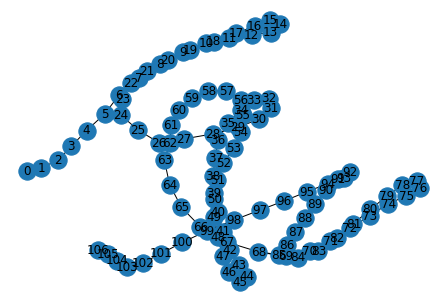

In [19]:
import networkx as nx 
  
A  =  Ss[0,:,:,0]
ones = np.ones(seq_length-1)
A += np.diag(ones,1) # add sequential edges (i,i+1) 
A += np.diag(ones,-1) # add sequential edges (i+1,i) (assume non-directed)

G = nx.from_numpy_matrix(np.array(A))
nx.draw(G, with_labels=True)

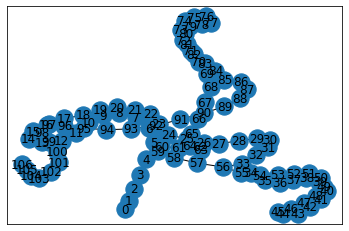

In [20]:
#  Try to make graph non-overlapping?
spring = nx.spring_layout(G)
nx.draw_networkx(G,spring)

### Look at bpps (first sample in training data)

In [10]:
a = np.load('data/bpps/id_001f94081.npy') 
print(a.shape)

(107, 107)


In [11]:
struct_adj[5,:]
five = a[5,:]

In [12]:
np.where(struct_adj[5,:] == 1)

(array([24], dtype=int64),)

In [13]:
np.argmax(five)

24

maximum bpps value matches the true adjacency matrix